In [32]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import json
import csv

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, AveragePooling1D, AveragePooling2D, concatenate, Input
from keras.initializers import Constant
from keras.optimizers import SGD, Adam
from keras.layers import TextVectorization
from keras import Model
from keras.src.optimizers.legacy.adadelta import Adadelta
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Set-up: Tokenizing and embedding

In [4]:
def read_corpus(corpus_file):
    """Read in review data set and returns docs and labels"""
    documents = []
    labels = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            tokens = line.strip()
            documents.append(" ".join(tokens.split()[:-1]).strip())
            labels.append(tokens.split()[-1])
    return documents, labels

In [5]:
def get_emb_matrix(voc, emb):
    """Get embedding matrix given vocab and the embeddings"""
    num_tokens = len(voc) + 2
    word_index = dict(zip(voc, range(len(voc))))
    # Bit hacky, get embedding dimension from the word "the"
    embedding_dim = len(emb["the"])
    # Prepare embedding matrix to the correct size
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = emb.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    # Final matrix with pretrained embeddings that we can feed to embedding layer
    return embedding_matrix

In [6]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
  return word_to_vec_map

In [8]:
X_train, y_train = read_corpus('/content/gdrive/MyDrive/University/learning_from_data/assignment_4/train.tsv')
X_val, y_val = read_corpus('/content/gdrive/MyDrive/University/learning_from_data/assignment_4/dev.tsv')
X_test, y_test = read_corpus('/content/gdrive/MyDrive/University/learning_from_data/assignment_4/test.tsv')

In [9]:
# For the sake of speed only load 50 dimensional vectors here
embeddings = read_glove_vector('/content/gdrive/MyDrive/University/learning_from_data/assignment_4/embeddings/glove.twitter.27B.200d.txt')

In [10]:
# Transform words to indices using a vectorizer
vectorizer = TextVectorization(standardize=None, output_sequence_length=50)
# Use train and dev to create vocab - could also do just train
text_ds = tf.data.Dataset.from_tensor_slices(X_train + X_val)
vectorizer.adapt(text_ds)

In [11]:
# Dictionary mapping words to idx
voc = vectorizer.get_vocabulary()
emb_matrix = get_emb_matrix(voc, embeddings)

In [12]:
# Transform string labels to one-hot encodings
encoder = LabelBinarizer()
y_train_bin = encoder.fit_transform(y_train)  # Use encoder.classes_ to find mapping back
y_val_bin = encoder.fit_transform(y_val)
y_test_bin = encoder.fit_transform(y_test)

In [13]:
# Transform input to vectorized input
X_train_vect = vectorizer(np.array([[s] for s in X_train])).numpy()
X_val_vect = vectorizer(np.array([[s] for s in X_val])).numpy()
X_test_vect = vectorizer(np.array([[s] for s in X_test])).numpy()

In [ ]:
embedding_dim = len(emb_matrix[0])
num_tokens = len(emb_matrix)
num_labels = len(set(y_train))

In [47]:
def evaluate(model, X_test, Y_test, ident):
    '''Do predictions and measure accuracy on our own test set (that we split off train)'''
    # Get predictions using the trained model
    Y_pred = model.predict(X_test)
    # Finally, convert to numerical labels to get scores with sklearn
    Y_pred = np.argmax(Y_pred, axis=1)
    # If you have gold data, you can calculate accuracy
    Y_test = np.argmax(Y_test, axis=1)
    print('Accuracy on own {1} set: {0}'.format(round(accuracy_score(Y_test, Y_pred), 3), ident))
    return accuracy_score(Y_test, Y_pred)

In [48]:
def create_model_adaptive(y_train, emb_matrix, learning_rate, loss_function, optimizer, layers, activation):
  """
  This method is a more generic version of the supplied create_model
  function.

  layers: This should contain a number of keras layers which are added to the
  model in sequence. This way, this function can generate models with different
  architectures.
  """

  # Take embedding dim and size from emb_matrix
  embedding_dim = len(emb_matrix[0])
  num_tokens = len(emb_matrix)
  num_labels = len(set(y_train))

  # We pass the class to the grid search and then instantiate here so that the
  # optimizer variables are freshly initialized each time
  optimizer_initialized = optimizer()

  # Set the learning rate here to make the grid search more elegant
  optimizer_initialized.learning_rate.assign(learning_rate)

  model = Sequential()
  model.add(Embedding(num_tokens, embedding_dim, embeddings_initializer=Constant(emb_matrix),trainable=False))

  for layer in layers:
    model.add(layer)

  model.add(Dense(input_dim=embedding_dim, units=1, activation=activation, name='output'))
  model.compile(loss=loss_function, optimizer=optimizer_initialized, metrics=['accuracy'])
  return model

In [49]:
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

In [50]:
def train_model_adaptive(model, X_train, y_train, X_val, y_val, epochs, batch_size):
  """
  This method is a more generic version of the supplied train_model function.
  """
  verbose = 1
  # Early stopping: stop training when there are three consecutive epochs without improving
  # It's also possible to monitor the training loss with monitor="loss"
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
  clear_memory_callback = ClearMemory()
  model.fit(X_train, y_train, verbose=verbose, epochs=epochs, callbacks=[callback, clear_memory_callback], batch_size=batch_size, validation_data=(X_val, y_val))
  return model

## Data exploration: t-SNE

In [51]:
def plot_2d_tsne(X, y):
  tsne = TSNE(n_components=2, init='random', perplexity=30, n_iter=250, random_state=0)
  X_tsne = tsne.fit_transform(X)
  X_tsne_df = pd.DataFrame.from_records(X_tsne, columns=['X_1', 'X_2'])
  X_tsne_df['y'] = y_train
  standard_scaler = StandardScaler()
  X_tsne_df['X_1'], X_tsne_df['X_2'] = standard_scaler.fit_transform(np.array([X_tsne_df['X_1'], X_tsne_df['X_2']]).T).T
  return X_tsne_df

In [273]:
initial_lstm_layers = [
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(64),
]

initial_lstm_model = create_model_adaptive(
  y_train=y_train,
  emb_matrix=emb_matrix,
  learning_rate=0.001,
  loss_function='mse',
  activation='sigmoid',
  optimizer=Adam,
  layers=initial_lstm_layers,
)

initial_lstm_model = train_model_adaptive(
  model=initial_lstm_model,
  X_train=X_train_vect,
  y_train=y_train_bin,
  X_val=X_val_vect,
  y_val=y_val_bin,
  epochs=50,
  batch_size=256,
)

Epoch 1/50
48/48 [==============================] - 8s 43ms/step - loss: 0.2236 - accuracy: 0.6666 - val_loss: 0.2051 - val_accuracy: 0.6930
Epoch 2/50
48/48 [==============================] - 2s 32ms/step - loss: 0.1893 - accuracy: 0.7240 - val_loss: 0.1816 - val_accuracy: 0.7460
Epoch 3/50
48/48 [==============================] - 3s 35ms/step - loss: 0.1754 - accuracy: 0.7519 - val_loss: 0.1834 - val_accuracy: 0.7370
Epoch 4/50
48/48 [==============================] - 2s 27ms/step - loss: 0.1704 - accuracy: 0.7569 - val_loss: 0.1746 - val_accuracy: 0.7410
Epoch 5/50
48/48 [==============================] - 2s 29ms/step - loss: 0.1657 - accuracy: 0.7670 - val_loss: 0.1823 - val_accuracy: 0.7400
Epoch 6/50
48/48 [==============================] - 2s 28ms/step - loss: 0.1641 - accuracy: 0.7715 - val_loss: 0.1764 - val_accuracy: 0.7380
Epoch 7/50
48/48 [==============================] - 2s 26ms/step - loss: 0.1591 - accuracy: 0.7797 - val_loss: 0.1785 - val_accuracy: 0.7390


In [274]:
extractor = Model(inputs=initial_lstm_model.inputs,
                        outputs=[layer.output for layer in initial_lstm_model.layers])
features = extractor(X_train_vect)

In [275]:
input = features[0]
lstm_output_1 = np.take(features[1], -1, axis=1) # Take last element her since sequences are returned
lstm_output_2 = np.take(features[2], -1, axis=1) # Take last element her since sequences are returned
lstm_output_3 = features[3]

intermediate_outputs = [
    (np.max(input, axis=1), 'Embeddings (max)'),
    (lstm_output_1, 'LSTM output (layer 1)'),
    (lstm_output_2, 'LSTM output (layer 2)'),
    (lstm_output_3, 'LSTM output (layer 3)'),
]

plot_df = pd.DataFrame({})

for X, name in intermediate_outputs:
  X_tsne_df = plot_2d_tsne(X, y_train)
  X_tsne_df['name'] = name
  plot_df = pd.concat([plot_df, X_tsne_df])

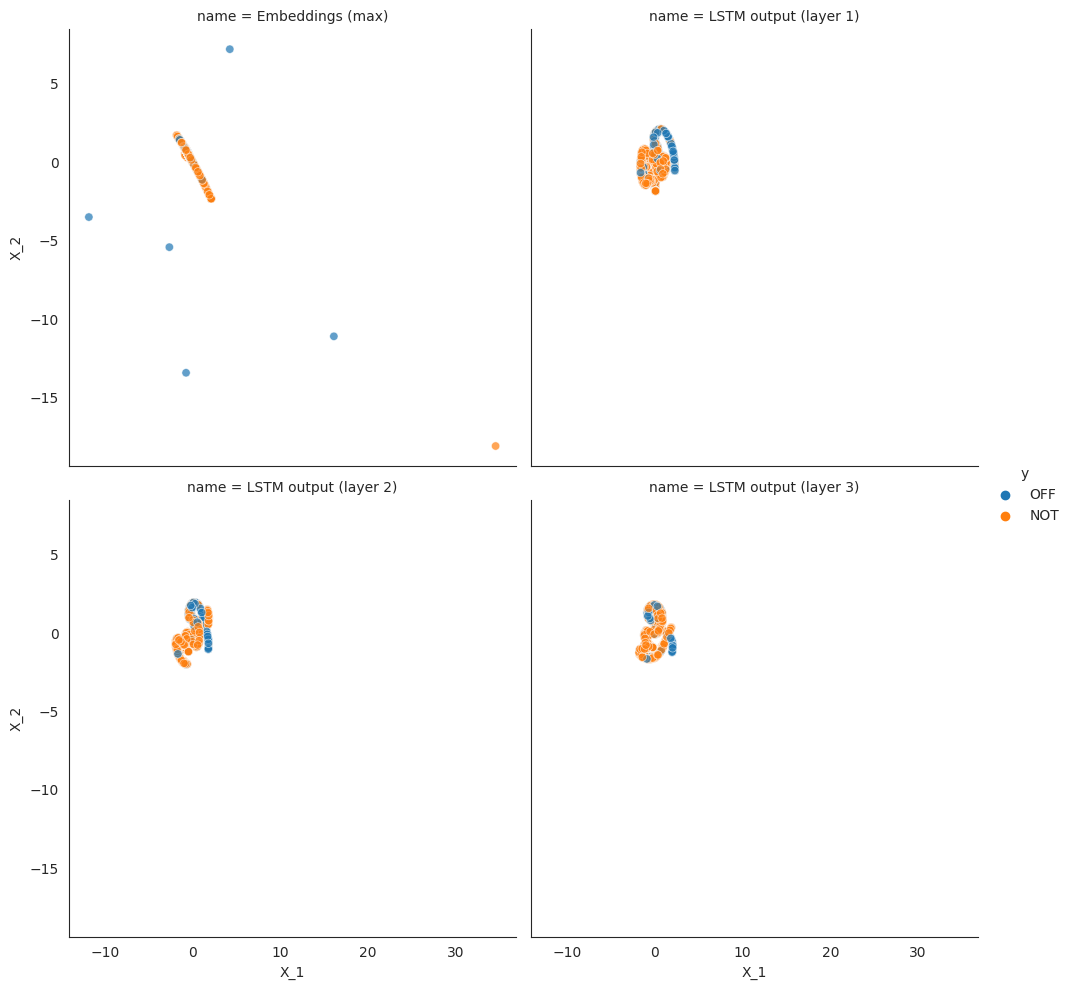

In [276]:
sns.relplot(data=plot_df, x='X_1', y='X_2', hue='y', col='name', alpha=0.7, col_wrap=2)

plt.savefig(f'/content/gdrive/MyDrive/University/learning_from_data/assignment_4/plots/manifold_{datetime.datetime.now().isoformat()}.svg')

## Data exploration: Imbalance with initial model predictions

In [56]:
def plot_confusion_matrix(y_test_bin, y_pred):
  cm = confusion_matrix(
  encoder.inverse_transform(y_test_bin),
  encoder.inverse_transform(y_pred),
  labels=encoder.classes_
  )
  sns.set_style('white')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
  disp.plot()
  plt.savefig('confusion.png')

In [57]:
y_pred = [[1] if n > 0.5 else [0] for [n] in initial_lstm_model.predict(X_test_vect)]

27/27 [==============================] - 1s 4ms/step


27/27 [==============================] - 0s 5ms/step


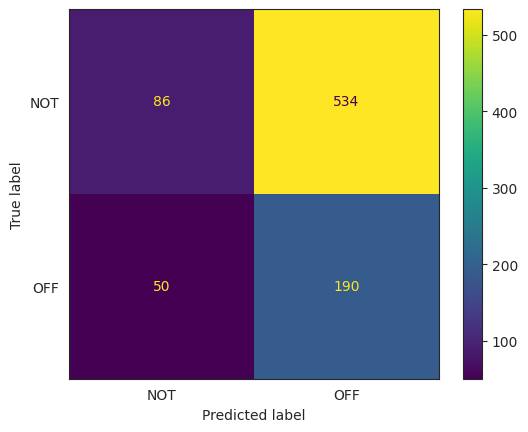

In [58]:
plot_confusion_matrix(y_test_bin, initial_lstm_model.predict(X_test_vect))

In [ ]:
print(classification_report(y_test_bin, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       620
           1       0.79      0.38      0.51       240

    accuracy                           0.80       860
   macro avg       0.79      0.67      0.69       860
weighted avg       0.80      0.80      0.77       860



## Set-up: Grid search functions

In [54]:
def run_grid_search(grid_search_params, emb_matrix, X_train_vect, y_train_bin, X_val_vect, y_val_bin, y_train, results_path, n_iterations, X_test_vect, y_test_bin):
  results = []

  for params in grid_search_params:
    for n_iteration in range(0, n_iterations):
      # This is a bit cryptic maybe, but it allows me to easily re-use this grid
      # search function with multiple architectures
      layers = params['set_up_function'](params)

      # Create model
      model = create_model_adaptive(
        y_train=y_train,
        emb_matrix=emb_matrix,
        learning_rate=params['learning_rate'],
        loss_function=params['loss_function'],
        optimizer=params['optimizer'],
        activation=params['activation'],
        layers=layers
      )
      # Train the model
      model = train_model_adaptive(
        model=model,
        X_train=X_train_vect,
        y_train=y_train_bin,
        X_val=X_val_vect,
        y_val=y_val_bin,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
      )
      results_with_params = params.copy()
      y_pred_val = [[1] if n > 0.5 else [0] for [n] in model.predict(X_val_vect)]
      y_pred_test = [[1] if n > 0.5 else [0] for [n] in model.predict(X_test_vect)]
      results_with_params['f1_score_validation'] = f1_score(y_val_bin, y_pred_val, average='macro')
      results_with_params['f1_score_test'] = f1_score(y_test_bin, y_pred_test, average='macro')
      results_with_params['run_number'] = n_iteration
      results.append(results_with_params)

  results_df = pd.DataFrame.from_records(results)
  results_df.to_csv(results_path)

In [55]:
def generate_grid_search_params_alternate_architectures():
  param_grid = {
    'learning_rate': [0.0005, 0.001, 0.003],
    'activation': ['sigmoid', 'relu'],
    'loss_function': ['mse', 'poisson'],
    'optimizer': [Adam],
    'batch_size': [64, 128, 256],
    'epochs': [50],
    'set_up_function': [
        set_up_candidate_one,
    ]
  }
  return ParameterGrid(param_grid)

In [59]:
def set_up_candidate_one(params):
  layers = []
  layers.append(Bidirectional(LSTM(64)))
  layers.append(Dense(64))
  return layers

## Grid search: Run and evaluation

In [34]:
grid_search_one_path = f'/content/gdrive/MyDrive/University/learning_from_data/assignment_4/results/grid_search_one_results.csv'

In [ ]:
run_grid_search(
    generate_grid_search_params_alternate_architectures(),
    emb_matrix,
    X_train_vect,
    y_train_bin,
    X_val_vect,
    y_val_bin,
    y_train,
    grid_search_one_path,
    3,
    X_test_vect,
    y_test_bin
)

Epoch 1/50
192/192 [==============================] - 12s 13ms/step - loss: 0.2070 - accuracy: 0.6910 - val_loss: 0.1828 - val_accuracy: 0.7390
Epoch 2/50
192/192 [==============================] - 2s 9ms/step - loss: 0.1788 - accuracy: 0.7441 - val_loss: 0.1779 - val_accuracy: 0.7430
Epoch 3/50
192/192 [==============================] - 2s 11ms/step - loss: 0.1699 - accuracy: 0.7572 - val_loss: 0.1798 - val_accuracy: 0.7370
Epoch 4/50
192/192 [==============================] - 3s 13ms/step - loss: 0.1646 - accuracy: 0.7658 - val_loss: 0.1728 - val_accuracy: 0.7490
Epoch 5/50
192/192 [==============================] - 2s 10ms/step - loss: 0.1604 - accuracy: 0.7771 - val_loss: 0.1769 - val_accuracy: 0.7380
Epoch 6/50
192/192 [==============================] - 2s 9ms/step - loss: 0.1550 - accuracy: 0.7848 - val_loss: 0.1800 - val_accuracy: 0.7350
Epoch 7/50
27/27 [==============================] - 0s 3ms/step
Epoch 1/50
192/192 [==============================] - 8s 21ms/step - loss: 0.20

In [35]:
grid_search_one_results = pd.read_csv(grid_search_one_path, index_col=0)

In [ ]:
grid_search_one_results.groupby('learning_rate')['f1_score_validation'].mean(), grid_search_one_results.groupby('learning_rate')['f1_score_validation'].std()

(learning_rate
 0.0005    0.683110
 0.0010    0.684878
 0.0030    0.663896
 Name: f1_score_validation, dtype: float64,
 learning_rate
 0.0005    0.036464
 0.0010    0.043555
 0.0030    0.076131
 Name: f1_score_validation, dtype: float64)

In [37]:
max_idx = grid_search_one_results.groupby(['epochs', 'learning_rate', 'activation', 'loss_function', 'batch_size', 'optimizer']).mean()['f1_score_validation'].idxmax()

<ipython-input-37-3e95c5e15e32>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  max_idx = grid_search_one_results.groupby(['epochs', 'learning_rate', 'activation', 'loss_function', 'batch_size', 'optimizer']).mean()['f1_score_validation'].idxmax()


In [41]:
grid_search_one_results.groupby(['epochs', 'learning_rate', 'activation', 'loss_function', 'batch_size', 'optimizer']).std().loc[max_idx]

<ipython-input-41-a462ac4317dc>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grid_search_one_results.groupby(['epochs', 'learning_rate', 'activation', 'loss_function', 'batch_size', 'optimizer']).std().loc[max_idx]


f1_score_validation    0.005852
f1_score_test          0.013419
run_number             1.000000
Name: (50, 0.001, relu, poisson, 64, <class 'keras.src.optimizers.adam.Adam'>), dtype: float64

In [45]:
max_idx

(50, 0.001, 'relu', 'poisson', 64, "<class 'keras.src.optimizers.adam.Adam'>")

## Evaluation: Offensiveness metric

Set-up model with best parameters from grid search

In [317]:
best_lstm_model = create_model_adaptive(
  y_train=y_train,
  emb_matrix=emb_matrix,
  learning_rate=0.001,
  loss_function='poisson',
  activation='relu',
  optimizer=Adam,
  layers=set_up_candidate_one([]),
)

best_lstm_model = train_model_adaptive(
  model=best_lstm_model,
  X_train=X_train_vect,
  y_train=y_train_bin,
  X_val=X_val_vect,
  y_val=y_val_bin,
  epochs=5,
  batch_size=64,
)

Epoch 1/5
192/192 [==============================] - 8s 18ms/step - loss: 0.6870 - accuracy: 0.6806 - val_loss: 0.6745 - val_accuracy: 0.7010
Epoch 2/5
192/192 [==============================] - 3s 12ms/step - loss: 0.6655 - accuracy: 0.7007 - val_loss: 0.6936 - val_accuracy: 0.6500
Epoch 3/5
192/192 [==============================] - 3s 12ms/step - loss: 0.6480 - accuracy: 0.7306 - val_loss: 0.6585 - val_accuracy: 0.7310
Epoch 4/5
192/192 [==============================] - 3s 12ms/step - loss: 0.6590 - accuracy: 0.7113 - val_loss: 0.6674 - val_accuracy: 0.7260
Epoch 5/5
192/192 [==============================] - 4s 17ms/step - loss: 0.6957 - accuracy: 0.6738 - val_loss: 0.6822 - val_accuracy: 0.7300


In [318]:
y_pred_test_best_raw = best_lstm_model.predict(X_test_vect)
y_pred_test_best = [[1] if n > 0.5 else [0] for [n] in best_lstm_model.predict(X_test_vect)]
y_pred_test_best_f1 = f1_score(y_test_bin, y_pred_test_best, average='macro')

27/27 [==============================] - 0s 3ms/step


In [319]:
y_pred_test_best_f1

0.6392377724614566

### Define offensiveness metric functions

In [307]:
def compute_word_frequency(X_test_vect, vocabulary):
  word_counts = {word: 0 for word in vocabulary}
  for sentence in X_train_vect:
    for word_index in sentence:
      if word_index != 0: # If the word exists in the vocabulary increment the occurence count
        word_counts[vocabulary[word_index]] += 1
  return word_counts

In [308]:
def compute_word_frequency_in_offensive_instances(X_test_vect, y_pred_test, vocabulary):
  total_offensive_classifications = sum([1 if predicted_label == [1] else 0 for predicted_label in y_pred_test])
  word_counts = {word: 0 for word in vocabulary}
  for (sentence, predicted_label) in zip(X_train_vect, y_pred_test):
    if predicted_label == [1]: # If the data instance is predicted as offensive add it's o
      for word_index in sentence:
        if word_index != 0:
          word_counts[vocabulary[word_index]] += (1)
  return {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}

In [309]:
def compute_normalized_word_frequency_in_offensive_instances(word_frequency, word_frequency_in_offensive_instances, voc, support_threshold):
  normalized_word_frequency_in_offensive_instances = {}
  for word in voc:
    if word_frequency[word] != 0 and word_frequency[word] >= support_threshold:
      normalized_word_frequency_in_offensive_instances[word] = word_frequency_in_offensive_instances[word] / word_frequency[word]
  return {k: v for k, v in sorted(normalized_word_frequency_in_offensive_instances.items(), key=lambda item: item[1], reverse=True)}

In [310]:
def compute_offensiveness_metric(X, y_pred, voc):
  word_frequency = compute_word_frequency(X, voc)
  word_frequency_in_offensive_instances = compute_word_frequency_in_offensive_instances(X, y_pred, voc)
  normalized_word_frequency_in_offensive_instances = compute_normalized_word_frequency_in_offensive_instances(word_frequency, word_frequency_in_offensive_instances, voc, 10)
  return normalized_word_frequency_in_offensive_instances

In [311]:
def classify_based_on_word_list(X, word_list):
  y_pred = []
  for sentence in X:
    prediction = [0]
    for word_token in sentence:
      if word_token in word_list:
        prediction = [1]
    y_pred.append(prediction)
  return y_pred

In [320]:
y_pred_train = [[1] if n > 0.5 else [0] for [n] in best_lstm_model.predict(X_train_vect)]
normalized_word_frequency_in_offensive_instances_train = compute_offensiveness_metric(X_train_vect, y_pred_train, voc)
word_list_train = list(normalized_word_frequency_in_offensive_instances_train.keys())[:100]
# This is a bit hacky, but use the tokenizer to convert the words back to their original token indexes
word_list_tokens_train = [int(word[0]) for word in vectorizer(word_list_train)]

383/383 [==============================] - 1s 3ms/step


In [321]:
y_pred_word_list = classify_based_on_word_list(X_test_vect, word_list_tokens_train)
f1_score(y_test_bin, y_pred_word_list, average='macro')

0.6486928104575163

In [323]:
word_list_train

['nigga',
 'nut',
 'bitch',
 'bitches',
 'disgusting',
 'fucked',
 'niggas',
 'fuck',
 'dumb',
 'dick',
 'crap',
 'nuts',
 'scum',
 'racists',
 'fucking',
 'idiot',
 'ass',
 'spoiled',
 'moron',
 'loser',
 'liar',
 'vile',
 'shit',
 'pussy',
 'stupid',
 'racist',
 'outrage',
 'dude',
 'hateful',
 'dirty',
 'weak',
 'gotta',
 'fascist',
 'ignorant',
 'destroying',
 'sick',
 'bigger',
 'mouth',
 'damn',
 'lying',
 'Holy',
 'ugly',
 'clown',
 'idiots',
 'delusional',
 'sucks',
 'hell',
 'fool',
 'bunch',
 'drunk',
 'honestly',
 'nobody',
 'quit',
 'thugs',
 'strangers',
 'nazi',
 'complaining',
 'ruined',
 'horrible',
 'tired',
 'ruin',
 'shit.',
 'bullshit',
 'trash',
 'republicans',
 'doesnt',
 'cops',
 'accusation',
 'scare',
 'gang',
 'fat',
 'lmao',
 'beating',
 'fake',
 'rape',
 'murder',
 'attacks',
 'mad',
 'dying',
 'piss',
 'letting',
 'hilarious',
 'filled',
 'apart',
 'hate',
 'hurt',
 'disgrace',
 'shame',
 'libs',
 'destroy',
 'babies',
 'somebody',
 'Tom',
 'create',
 'oh',